# Parameter Fine-Tuning for Q-Variance Model

This notebook optimizes the model parameters **SIGMA0** (σ₀) and **MU** (μ) to maximize the Figure 1 R² score (q-variance parabola fit).

You can also tweak **SAMPLES_PER_DAY** and **MAX_WINDOW_DAYS** to explore their impact on model performance.

## 1. Setup and Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit, minimize, differential_evolution
from scipy.stats import norm, poisson
from sklearn.metrics import r2_score
from pathlib import Path
import sys
import subprocess
import os
import tempfile
import shutil

# Set up paths
NOTEBOOK_DIR = Path.cwd()
CHALLENGE_ROOT = NOTEBOOK_DIR.parent.parent
DATA_LOADER_SCRIPT = CHALLENGE_ROOT / 'code' / 'data_loader_csv.py'

# Add paths for imports
sys.path.insert(0, str(NOTEBOOK_DIR))
sys.path.insert(0, str(CHALLENGE_ROOT))
sys.path.insert(0, str(CHALLENGE_ROOT / 'code'))

# Import model functions
from model_simulation import generate_price_csv

print(f"Notebook directory: {NOTEBOOK_DIR}")
print(f"Challenge root: {CHALLENGE_ROOT}")
print(f"Data loader script: {DATA_LOADER_SCRIPT}")

Notebook directory: /Users/thijs/Projects/challenge/submissions/2001_a_state_space_odyssey
Challenge root: /Users/thijs/Projects/challenge
Data loader script: /Users/thijs/Projects/challenge/code/data_loader_csv.py


## 2. Helper Functions

Define the q-variance function and quantum density function used for fitting.

In [2]:
def qvar(z, s0, zoff):
    """Q-variance function: σ²(z) = σ₀² + (z - z₀)²/2"""
    return (s0**2 + (z - zoff)**2 / 2)


def quantum_density(z, sig0, zoff=0.0):
    """Quantum density function — returns plain array for curve_fit"""
    ns = np.arange(0, 6)
    qdn = np.zeros_like(z, dtype=float)
    sigvec = sig0 * np.sqrt(2 * ns + 1)
    means = zoff * np.ones_like(ns) - sigvec**2/2  # no drift term in pure Q-Variance

    for n in ns:
        weight = poisson.pmf(n, mu=0.5)
        qdn += weight * norm.pdf(z, loc=means[n], scale=sigvec[n])
    return qdn

print("✓ Helper functions defined")

✓ Helper functions defined


## 3. Parameter Evaluation Function

This function evaluates a set of parameters by:
1. Generating a price simulation
2. Processing it through the data loader
3. Calculating the Figure 1 R² score

In [3]:
def evaluate_parameters(sigma0, mu, samples_per_day=4, max_window_days=130, 
                        n_days=5_000_000, seed=42, verbose=False):
    """
    Evaluate model parameters by generating simulation and calculating R².
    
    Parameters:
    -----------
    sigma0 : float
        Baseline variance scale (σ₀)
    mu : float
        Drift per year (μ)
    samples_per_day : int
        Internal steps per day (default: 4)
    max_window_days : int
        Maximum window size in days (default: 130)
    n_days : int
        Number of trading days to simulate (default: 5_000_000)
    seed : int
        Random seed for reproducibility (default: 42)
    verbose : bool
        Print progress messages (default: False)
    
    Returns:
    --------
    r2 : float
        Figure 1 R² score (q-variance parabola fit)
    """
    try:
        # Create temporary directory for this evaluation
        with tempfile.TemporaryDirectory() as tmpdir:
            tmp_path = Path(tmpdir)
            csv_file = tmp_path / 'variance_timeseries.csv'
            dataset_file = tmp_path / 'dataset.parquet'
            
            # Step 1: Generate price simulation
            if verbose:
                print(f"  Generating simulation: σ₀={sigma0:.4f}, μ={mu:.4f}")
            generate_price_csv(
                sigma0=sigma0,
                mu=mu,
                n_days=n_days,
                samples_per_day=samples_per_day,
                max_window_days=max_window_days,
                output_file=str(csv_file),
                seed=seed
            )
            
            # Step 2: Process through data_loader_csv.py
            if verbose:
                print(f"  Processing through data loader...")
            
            # Change to challenge root for data loader
            original_cwd = os.getcwd()
            os.chdir(CHALLENGE_ROOT)
            
            # Copy CSV to challenge root (where data_loader expects it)
            temp_csv = CHALLENGE_ROOT / 'variance_timeseries.csv'
            shutil.copy(csv_file, temp_csv)
            
            # Run data loader
            result = subprocess.run(
                [sys.executable, str(DATA_LOADER_SCRIPT)],
                capture_output=True,
                text=True
            )
            
            # Move dataset.parquet to temp directory
            challenge_dataset = CHALLENGE_ROOT / 'dataset.parquet'
            if challenge_dataset.exists():
                shutil.move(str(challenge_dataset), str(dataset_file))
            
            # Clean up temp CSV
            if temp_csv.exists():
                temp_csv.unlink()
            
            os.chdir(original_cwd)
            
            # Step 3: Load dataset and calculate R²
            if not dataset_file.exists():
                if verbose:
                    print(f"  Warning: dataset.parquet not created")
                return -1.0  # Return low score on failure
            
            data = pd.read_parquet(dataset_file)
            data["var"] = data.sigma**2
            
            if len(data) == 0:
                if verbose:
                    print(f"  Warning: empty dataset")
                return -1.0
            
            # Calculate Figure 1 R² (q-variance parabola fit)
            zmax = 0.6
            delz = 0.025 * 2
            nbins = int(2 * zmax / delz + 1)
            bins = np.linspace(-zmax, zmax, nbins)
            
            # Create binned data
            binned = (data.assign(z_bin=pd.cut(data.z, bins=bins, include_lowest=True))
                           .groupby('z_bin', observed=False)
                           .agg(z_mid=('z', 'mean'), var=('var', 'mean'))
                           .dropna())
            
            if len(binned) < 3:
                if verbose:
                    print(f"  Warning: insufficient binned data")
                return -1.0
            
            # Fit q-variance curve
            try:
                popt, _ = curve_fit(qvar, binned.z_mid, binned["var"], p0=[0.25, 0.02])
                fitted = qvar(binned.z_mid, popt[0], popt[1])
                r2 = 1 - np.sum((binned["var"] - fitted)**2) / np.sum((binned["var"] - binned["var"].mean())**2)
            except:
                if verbose:
                    print(f"  Warning: curve fitting failed")
                return -1.0
            
            if verbose:
                print(f"  R² = {r2:.4f}")
            
            return r2
            
    except Exception as e:
        if verbose:
            print(f"  Error: {e}")
        return -1.0  # Return low score on error

print("✓ Parameter evaluation function defined")

✓ Parameter evaluation function defined


## 4. Simulation Parameters (Tweakable)

You can modify these parameters to explore their impact on model performance.

In [4]:
# Simulation parameters (can be tweaked)
SAMPLES_PER_DAY = 4      # Internal steps per day for simulation granularity
MAX_WINDOW_DAYS = 130     # Maximum window size in days (for regime length heuristic)
N_DAYS = 5_000_000        # Number of trading days to simulate
SEED = 42                 # Random seed for reproducibility

print(f"Simulation settings:")
print(f"  SAMPLES_PER_DAY = {SAMPLES_PER_DAY}")
print(f"  MAX_WINDOW_DAYS = {MAX_WINDOW_DAYS}")
print(f"  N_DAYS = {N_DAYS:,}")
print(f"  SEED = {SEED}")

Simulation settings:
  SAMPLES_PER_DAY = 4
  MAX_WINDOW_DAYS = 130
  N_DAYS = 5,000,000
  SEED = 42


## 5. Parameter Optimization

Optimize SIGMA0 and MU to maximize Figure 1 R² score.

In [5]:
# Parameter bounds
SIGMA0_BOUNDS = (0.1, 0.5)   # Baseline variance scale
MU_BOUNDS = (-0.05, 0.1)     # Drift per year

# Initial guess (current values from generate_submission.py)
INITIAL_GUESS = [0.25, 0.02]

# Store optimization history
optimization_history = []

def objective_function(params):
    """Objective function for optimization (minimize negative R²)"""
    sigma0, mu = params
    r2 = evaluate_parameters(
        sigma0=sigma0,
        mu=mu,
        samples_per_day=SAMPLES_PER_DAY,
        max_window_days=MAX_WINDOW_DAYS,
        n_days=N_DAYS,
        seed=SEED,
        verbose=False
    )
    # Print parameters and R² for each evaluation
    print(f"  σ₀={sigma0:.4f}, μ={mu:.4f} → R²={r2:.6f}")
    # Store history
    optimization_history.append({
        'sigma0': sigma0,
        'mu': mu,
        'r2': r2
    })
    # Return negative R² for minimization
    return -r2

print("✓ Optimization setup complete")
print(f"  Parameter bounds: SIGMA0 ∈ [{SIGMA0_BOUNDS[0]}, {SIGMA0_BOUNDS[1]}], MU ∈ [{MU_BOUNDS[0]}, {MU_BOUNDS[1]}]")
print(f"  Initial guess: SIGMA0 = {INITIAL_GUESS[0]}, MU = {INITIAL_GUESS[1]}")

✓ Optimization setup complete
  Parameter bounds: SIGMA0 ∈ [0.1, 0.5], MU ∈ [-0.05, 0.1]
  Initial guess: SIGMA0 = 0.25, MU = 0.02


### Run Optimization

This may take a while as each evaluation requires generating a full simulation.

**Note:** We use `differential_evolution` instead of gradient-based optimizers (like L-BFGS-B) because:
- The objective function is stochastic (due to random simulation), making gradients unreliable
- It's a global optimizer that explores the entire parameter space, not just local regions
- It doesn't get stuck at the initial guess or local minima
- It's robust to noisy objective functions

In [6]:
# Clear history
optimization_history = []

print("Starting optimization...")
print("=" * 60)
print("Using differential_evolution (global optimizer, robust to local minima)")
print("=" * 60)

# First, let's test the objective function at the initial guess to see if it's working
print(f"\nTesting objective function at initial guess:")
print(f"  SIGMA0 = {INITIAL_GUESS[0]}, MU = {INITIAL_GUESS[1]}")
test_r2 = evaluate_parameters(
    sigma0=INITIAL_GUESS[0],
    mu=INITIAL_GUESS[1],
    samples_per_day=SAMPLES_PER_DAY,
    max_window_days=MAX_WINDOW_DAYS,
    n_days=N_DAYS,
    seed=SEED,
    verbose=True
)
print(f"  Initial R² = {test_r2:.6f}\n")

# Run optimization using differential_evolution (global optimizer, doesn't rely on gradients)
# This method uses a population-based approach and is much better at escaping local minima
result = differential_evolution(
    objective_function,
    bounds=[SIGMA0_BOUNDS, MU_BOUNDS],
    seed=SEED,  # For reproducibility
    maxiter=15,  # Number of generations (adjust as needed)
    popsize=5,   # Population size (smaller = faster, but less exploration)
    mutation=(0.5, 1),  # Mutation factor range
    recombination=0.7,  # Crossover probability
    strategy='best1bin',  # Strategy for mutation
    polish=True,  # Polish the best solution with a local optimizer
    disp=True,  # Print progress
    atol=1e-6,  # Absolute tolerance for convergence
    tol=1e-6    # Relative tolerance for convergence
)

print("=" * 60)
print("Optimization complete!")
print(f"\nBest parameters found:")
print(f"  SIGMA0 = {result.x[0]:.6f}")
print(f"  MU     = {result.x[1]:.6f}")
print(f"  Best R² = {-result.fun:.6f}")
print(f"\nOptimization status: {result.message}")
print(f"Number of iterations: {result.nit}")
print(f"Number of function evaluations: {result.nfev}")

# Store best parameters
BEST_SIGMA0 = result.x[0]
BEST_MU = result.x[1]
BEST_R2 = -result.fun

Starting optimization...
Using differential_evolution (global optimizer, robust to local minima)

Testing objective function at initial guess:
  SIGMA0 = 0.25, MU = 0.02
  Generating simulation: σ₀=0.2500, μ=0.0200
Generated 5000001 price points
Saved to /var/folders/5g/0dhhbmg52yd5rkn3lr8br8mh0000gn/T/tmpllczclnx/variance_timeseries.csv
  Processing through data loader...
  R² = 0.9987
  Initial R² = 0.998666

Generated 5000001 price points
Saved to /var/folders/5g/0dhhbmg52yd5rkn3lr8br8mh0000gn/T/tmpzakrsvwe/variance_timeseries.csv
  σ₀=0.1693, μ=0.0779 → R²=0.992339
Generated 5000001 price points
Saved to /var/folders/5g/0dhhbmg52yd5rkn3lr8br8mh0000gn/T/tmpah9tg0v6/variance_timeseries.csv
  σ₀=0.3008, μ=-0.0177 → R²=0.999111
Generated 5000001 price points
Saved to /var/folders/5g/0dhhbmg52yd5rkn3lr8br8mh0000gn/T/tmphm3a5w9y/variance_timeseries.csv
  σ₀=0.2840, μ=0.0395 → R²=0.999142
Generated 5000001 price points
Saved to /var/folders/5g/0dhhbmg52yd5rkn3lr8br8mh0000gn/T/tmpfmsw6g_h/

## 6. Visualization

### 6.1 Optimization Progress

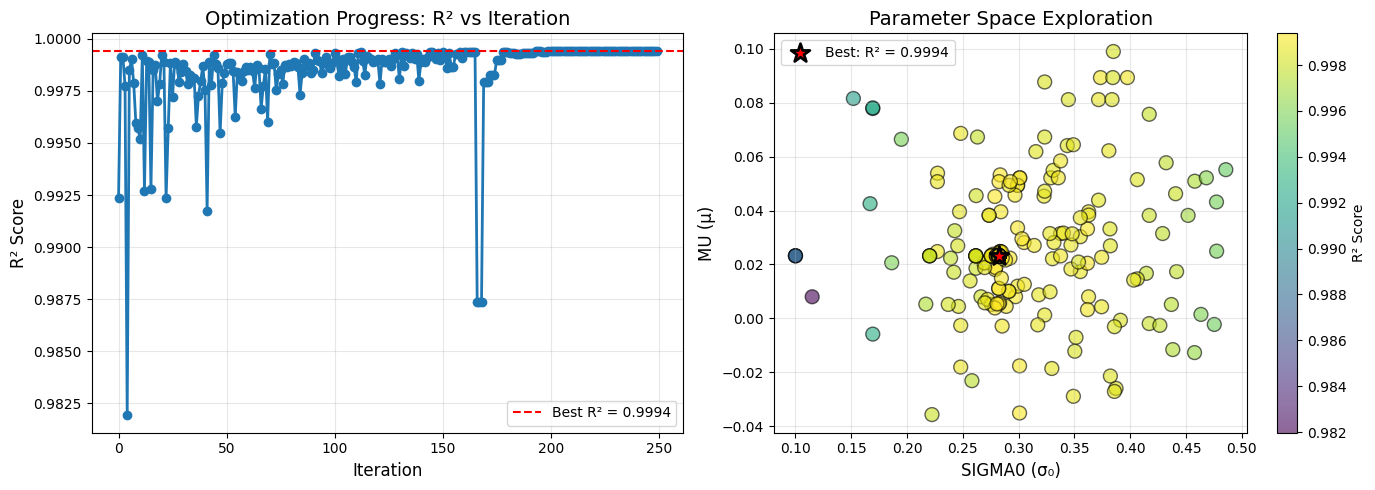


Optimization history summary:
  Total evaluations: 250
  R² range: [0.9820, 0.9994]


In [11]:
# Plot optimization progress
if len(optimization_history) > 0:
    history_df = pd.DataFrame(optimization_history)
    
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # R² vs iteration
    axes[0].plot(history_df['r2'], 'o-', linewidth=2, markersize=6)
    axes[0].axhline(y=BEST_R2, color='r', linestyle='--', label=f'Best R² = {BEST_R2:.4f}')
    axes[0].set_xlabel('Iteration', fontsize=12)
    axes[0].set_ylabel('R² Score', fontsize=12)
    axes[0].set_title('Optimization Progress: R² vs Iteration', fontsize=14)
    axes[0].grid(alpha=0.3)
    axes[0].legend()
    
    # Parameter space exploration
    scatter = axes[1].scatter(history_df['sigma0'], history_df['mu'], 
                             c=history_df['r2'], cmap='viridis', 
                             s=100, alpha=0.6, edgecolors='black', linewidth=1)
    axes[1].scatter(BEST_SIGMA0, BEST_MU, color='red', s=200, 
                   marker='*', edgecolors='black', linewidth=2, 
                   label=f'Best: R² = {BEST_R2:.4f}', zorder=10)
    axes[1].set_xlabel('SIGMA0 (σ₀)', fontsize=12)
    axes[1].set_ylabel('MU (μ)', fontsize=12)
    axes[1].set_title('Parameter Space Exploration', fontsize=14)
    axes[1].grid(alpha=0.3)
    axes[1].legend()
    plt.colorbar(scatter, ax=axes[1], label='R² Score')
    
    plt.tight_layout()
    plt.show()
    
    print(f"\nOptimization history summary:")
    print(f"  Total evaluations: {len(history_df)}")
    print(f"  R² range: [{history_df['r2'].min():.4f}, {history_df['r2'].max():.4f}]")
else:
    print("No optimization history available")

### 6.2 Generate Figures for Best Model

Generate Figure_1 and Figure_5 for the optimal parameters.

In [8]:
def generate_figures_inline(dataset_path):
    """Generate Figure_1 and Figure_5 plots inline in notebook"""
    data = pd.read_parquet(dataset_path)
    data["var"] = data.sigma**2
    
    print(f"Loaded {len(data)} windows")
    
    # ===== Figure 1: Q-Variance scatter plot =====
    zmax = 0.6
    delz = 0.025 * 2
    nbins = int(2 * zmax / delz + 1)
    bins = np.linspace(-zmax, zmax, nbins)
    
    # Create binned data
    binned = (data.assign(z_bin=pd.cut(data.z, bins=bins, include_lowest=True))
                   .groupby('z_bin', observed=False)
                   .agg(z_mid=('z', 'mean'), var=('var', 'mean'))
                   .dropna())
    
    # Fit q-variance curve
    popt, _ = curve_fit(qvar, binned.z_mid, binned["var"], p0=[0.25, 0.02])
    fitted = qvar(binned.z_mid, popt[0], popt[1])
    r2 = 1 - np.sum((binned["var"] - fitted)**2) / np.sum((binned["var"] - binned["var"].mean())**2)
    
    print(f"Figure 1 - σ₀ = {popt[0]:.4f}  zoff = {popt[1]:.4f}  R² = {r2:.4f}")
    
    # Plot Figure 1
    fig1, ax1 = plt.subplots(figsize=(9, 7))
    markfac = 1
    ax1.scatter(data.z, data['var'], c='steelblue', alpha=markfac*0.1, s=markfac*1, edgecolor='none')
    ax1.plot(binned.z_mid, binned['var'], 'b-', lw=3, label='Binned data')
    ax1.plot(binned.z_mid, fitted, 'red', lw=3, 
             label=f'σ₀ = {popt[0]:.3f}, zoff = {popt[1]:.3f}, R² = {r2:.3f}')
    ax1.set_xlabel('z (scaled log return)', fontsize=12)
    ax1.set_ylabel('Annualised variance', fontsize=12)
    ax1.set_title('Q-Variance: all data T=1 to 26 weeks', fontsize=14)
    ax1.set_xlim(-zmax, zmax)
    ax1.set_ylim(0.0, 0.35)
    ax1.legend(fontsize=12)
    ax1.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    # ===== Figure 5: Time-invariant distribution =====
    zlim = 2
    zbins = np.linspace(-zlim, zlim, 51)
    zmid = (zbins[:-1] + zbins[1:]) / 2
    
    # Histogram for all data
    counts, _ = np.histogram(data["z"], bins=zbins, density=True)
    
    # Fit quantum model
    p0 = [0.62, 0.0]
    popt_q, _ = curve_fit(quantum_density, zmid, counts, p0=p0, bounds=(0, [2.0, 0.5]))
    sig0_fit, zoff_fit = popt_q
    
    # Predict on fine grid
    z_fine = np.linspace(-zlim, zlim, 1000)
    q_pred_fine = quantum_density(z_fine, *popt_q)
    
    # Predict on histogram bin centers for R²
    q_pred_hist = quantum_density(zmid, *popt_q)
    r2_all = r2_score(counts, q_pred_hist)
    
    print(f"Figure 5 - Fit: σ₀ = {sig0_fit:.4f}, zoff = {zoff_fit:.4f}, R² = {r2_all:.4f}")
    
    # Plot with different periods
    TVEC = [5, 10, 20, 40, 80]
    
    fig5, ax5 = plt.subplots(figsize=(9, 7))
    ax5.plot(z_fine, q_pred_fine,
             color='red', lw=4,
             label=f'Q-Variance fit: σ₀ = {sig0_fit:.3f}, R² = {r2_all:.4f}')
    
    for Tcur in TVEC:
        datacur = data[(data["T"] == Tcur)].copy()
        if len(datacur) > 0:
            counts_cur, _, _ = plt.hist(datacur["z"], bins=zbins, density=True, visible=False)
            r2_cur = r2_score(counts_cur, q_pred_hist)  # use fit for whole data set
            colcur = str(Tcur / (max(TVEC) + 20))
            ax5.plot(zmid, counts_cur, c=colcur, lw=2, 
                    label=f'T = {Tcur/5:.0f}, R² = {r2_cur:.3f}')
    
    ax5.set_title('Q-Variance: T dependence', fontsize=18, pad=20)
    ax5.set_xlabel('Scaled log-return z', fontsize=14)
    ax5.set_ylabel('Density', fontsize=14)
    ax5.set_xlim(-1.2, 1.2)
    ax5.legend(fontsize=10, loc='upper right')
    ax5.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    return r2, r2_all

print("✓ Figure generation function defined")

✓ Figure generation function defined


Generating dataset for best parameters...
SIGMA0 = 0.282388, MU = 0.023182
Generated 5000001 price points
Saved to /var/folders/5g/0dhhbmg52yd5rkn3lr8br8mh0000gn/T/tmpbbjqa796/variance_timeseries.csv

Generating figures for best model...
Loaded 3854413 windows
Figure 1 - σ₀ = 0.2756  zoff = 0.0025  R² = 0.9994


/var/folders/5g/0dhhbmg52yd5rkn3lr8br8mh0000gn/T/ipykernel_63615/3503179787.py:41: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
/Users/thijs/Projects/challenge/submissions/2001_a_state_space_odyssey/.venv/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


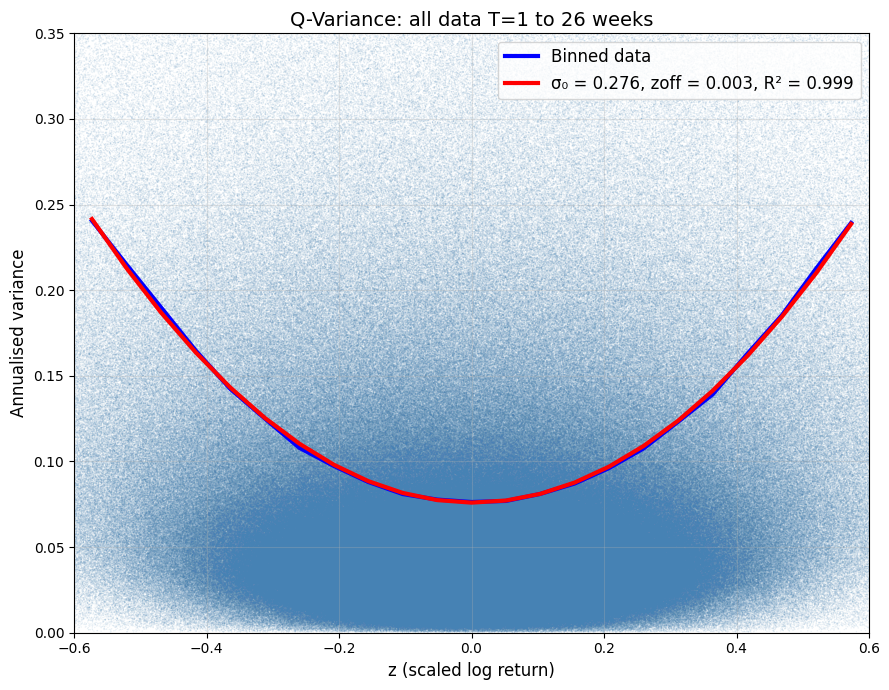

Figure 5 - Fit: σ₀ = 0.2102, zoff = 0.0316, R² = 0.9970


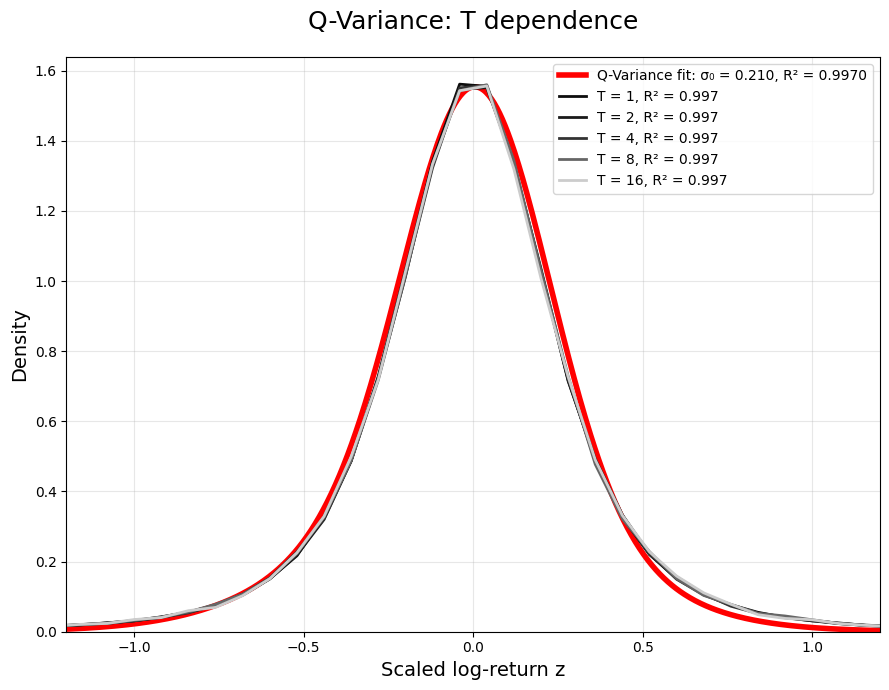


Final Results:
  Figure 1 R² = 0.999384
  Figure 5 R² = 0.997026


In [9]:
# Generate dataset for best parameters
print("Generating dataset for best parameters...")
print(f"SIGMA0 = {BEST_SIGMA0:.6f}, MU = {BEST_MU:.6f}")
print("=" * 60)

# Create temporary directory for best model
with tempfile.TemporaryDirectory() as tmpdir:
    tmp_path = Path(tmpdir)
    csv_file = tmp_path / 'variance_timeseries.csv'
    dataset_file = tmp_path / 'dataset.parquet'
    
    # Generate simulation
    generate_price_csv(
        sigma0=BEST_SIGMA0,
        mu=BEST_MU,
        n_days=N_DAYS,
        samples_per_day=SAMPLES_PER_DAY,
        max_window_days=MAX_WINDOW_DAYS,
        output_file=str(csv_file),
        seed=SEED
    )
    
    # Process through data loader
    original_cwd = os.getcwd()
    os.chdir(CHALLENGE_ROOT)
    
    temp_csv = CHALLENGE_ROOT / 'variance_timeseries.csv'
    shutil.copy(csv_file, temp_csv)
    
    result = subprocess.run(
        [sys.executable, str(DATA_LOADER_SCRIPT)],
        capture_output=True,
        text=True
    )
    
    challenge_dataset = CHALLENGE_ROOT / 'dataset.parquet'
    if challenge_dataset.exists():
        shutil.move(str(challenge_dataset), str(dataset_file))
    
    if temp_csv.exists():
        temp_csv.unlink()
    
    os.chdir(original_cwd)
    
    # Generate figures
    if dataset_file.exists():
        print("\nGenerating figures for best model...")
        r2_fig1, r2_fig5 = generate_figures_inline(dataset_file)
        print(f"\nFinal Results:")
        print(f"  Figure 1 R² = {r2_fig1:.6f}")
        print(f"  Figure 5 R² = {r2_fig5:.6f}")
    else:
        print("Error: Could not generate dataset for best parameters")

## 7. Summary

Best parameters found and recommended values for `generate_submission.py`.

In [10]:
print("=" * 60)
print("OPTIMIZATION SUMMARY")
print("=" * 60)
print(f"\nBest Parameters Found:")
print(f"  SIGMA0 = {BEST_SIGMA0:.6f}")
print(f"  MU     = {BEST_MU:.6f}")
print(f"  Best R² = {BEST_R2:.6f}")
print(f"\nSimulation Settings Used:")
print(f"  SAMPLES_PER_DAY = {SAMPLES_PER_DAY}")
print(f"  MAX_WINDOW_DAYS = {MAX_WINDOW_DAYS}")
print(f"  N_DAYS = {N_DAYS:,}")
print(f"  SEED = {SEED}")
print(f"\nRecommended values for generate_submission.py:")
print(f"  SIGMA0 = {BEST_SIGMA0:.6f}  # Baseline variance scale (σ₀)")
print(f"  MU = {BEST_MU:.6f}  # Drift per year (z₀)")
print(f"  SAMPLES_PER_DAY = {SAMPLES_PER_DAY}  # Internal steps per day")
print(f"  MAX_WINDOW_DAYS = {MAX_WINDOW_DAYS}  # Maximum window size in days")

OPTIMIZATION SUMMARY

Best Parameters Found:
  SIGMA0 = 0.282388
  MU     = 0.023182
  Best R² = 0.999384

Simulation Settings Used:
  SAMPLES_PER_DAY = 4
  MAX_WINDOW_DAYS = 130
  N_DAYS = 5,000,000
  SEED = 42

Recommended values for generate_submission.py:
  SIGMA0 = 0.282388  # Baseline variance scale (σ₀)
  MU = 0.023182  # Drift per year (z₀)
  SAMPLES_PER_DAY = 4  # Internal steps per day
  MAX_WINDOW_DAYS = 130  # Maximum window size in days
